<a href="https://colab.research.google.com/github/raaraya1/Personal-Proyects/blob/main/Cursos/sklearn/Agglomerative_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Agglomerative Clustering**

Fuente: https://www.youtube.com/watch?v=RdT7bhm1M3E&t=401s&ab_channel=AnuradhaBhatia

Agglomerative Clustering es un tipo de algortimo que agrupa de manera jerarquica. De esta manera lo que se hace es considerar a cada observacion como un cluster y luego ir juntando aquellos que sean mas similares. Esto lo repetimos hasta alcanzar un numero de clusters deseado.

**Metodo**
 - Inicializamos todos los puntos como clusters
 - Tomamos dos clusters que se encuentren cercanos y los unificacamos en un unico cluster.
 - Repetimos el paso anterior hasta conseguir un numero de clusters deseado.

**Criterios para medir la similitud entre clusters**

 - Distancia entre los puntos **mas cercanos** de dos clusters distintos.
 - Distancia entre los puntos **mas lejanos** de dos clusters distintos.
 - Distancia entre los promedios de cada cluster.
 

# **Armando el algoritmo desde cero**

**Nota:** Lo voy a armar con el fin de conseguir los mismos resultados que en el video.

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
# Observaciones
# Nota: lo voy a trabajar con la misma estructura de sklearn (n_sample, features)

X = np.array([[0.4, 0.53], 
             [0.22, 0.38], 
             [0.35, 0.32], 
             [0.26, 0.19], 
             [0.08, 0.41], 
             [0.45, 0.3]])
X.shape

(6, 2)

In [ ]:
def dist(x1, x2):
  return np.round(np.sqrt(((x1 - x2)**2).sum()), 2)

In [ ]:
distance = dist(X[1, :], X[1, :])
distance

# distance matrix
dis_matrix = []
for i in range(X.shape[0]):
  dis_matrix.append([])
  for j in range(X.shape[0]):
    dis_matrix[i].append(dist(X[i, :], X[j, :]))

dis_matrix = np.array(dis_matrix)
df = pd.DataFrame(dis_matrix)
columnas = [f'P{i+1}' for i in df.columns]
filas = [f'P{i+1}' for i in df.index]
df.columns = columnas
df.index = filas
df

,P1,P2,P3,P4,P5,P6
P1,0.00,0.23,0.22,0.37,0.34,0.24
P2,0.23,0.00,0.14,0.19,0.14,0.24
P3,0.22,0.14,0.00,0.16,0.28,0.10
P4,0.37,0.19,0.16,0.00,0.28,0.22
P5,0.34,0.14,0.28,0.28,0.00,0.39
P6,0.24,0.24,0.10,0.22,0.39,0.00


In [ ]:
# ahora vamos a definir una funcion para extraer los indices donde se encuentra el minimo
value = 1000000 # valor muy grande
fila = None
columna = None
for i in df.index:
  for j in df.columns:
    if df[i][j] < value and df[i][j] != 0:
      value = df[i][j]
      fila = i
      columna = j

print((fila, columna))

('P3', 'P6')


In [ ]:
# Esto mismo lo voy a dejar como funcion
def min_indices(df, value=100000):
  fila = None
  columna = None
  for i in df.index:
    for j in df.columns:
      if df[i][j] < value and df[i][j] != 0:
        value = df[i][j]
        fila = i
        columna = j
  return fila, columna
fila, columna = min_indices(df)
print((fila, columna))

('P3', 'P6')


In [ ]:
# Calculamos los nuevos valores
old_columns = [i for i in df.columns if i != fila and i != columna]
old_rows = [i for i in df.index if i != fila and i != columna]

def min_cluster(df, current_row, fila, columna):
  option = np.argmin([df[current_row][fila], df[current_row][columna]])
  if option == 0:
    return fila 
  elif option == 1:
    return columna

new_row = [df[i][min_cluster(df, i, fila, columna)] for i in old_rows]
new_row

[0.22, 0.14, 0.16, 0.28]

In [ ]:
# Rescatamos los valores antiguos
old_columns = [i for i in df.columns if i != fila and i != columna]
old_rows = [i for i in df.index if i != fila and i != columna]
df_new = df[df.index.isin(old_rows)]
df_new = df_new[old_columns] 
df_new

,P1,P2,P4,P5
P1,0.00,0.23,0.37,0.34
P2,0.23,0.00,0.19,0.14
P4,0.37,0.19,0.00,0.28
P5,0.34,0.14,0.28,0.00


In [ ]:
# Agregamos los valores nuevos
df_new['c1'] = new_row
df_new

,P1,P2,P4,P5,c1
P1,0.00,0.23,0.37,0.34,0.22
P2,0.23,0.00,0.19,0.14,0.14
P4,0.37,0.19,0.00,0.28,0.16
P5,0.34,0.14,0.28,0.00,0.28


In [ ]:
new_row.append(0)
df_new.loc['c1'] = new_row
df_new

,P1,P2,P4,P5,c1
P1,0.00,0.23,0.37,0.34,0.22
P2,0.23,0.00,0.19,0.14,0.14
P4,0.37,0.19,0.00,0.28,0.16
P5,0.34,0.14,0.28,0.00,0.28
c1,0.22,0.14,0.16,0.28,0.00


## **Uniendo todo**

In [ ]:
from pandas.core import algorithms
# Intentemos unir todo

class Agglo_clust():
  def __init__(self, n_cluster):
    self.n_cluster = n_cluster

  def dist(x1, x2):
    return np.round(np.sqrt(((x1 - x2)**2).sum()), 2)

  def solve(self, X):
    # Inicializamos 
    df = self.initializer(X)
    current_clusters = self.current_clusters(df)

    n_iters = current_clusters - self.n_cluster
    for i in range(n_iters):
      # calculamos los puntos que vamos a agrupar 
      fil, col = self.min_indices(df)
      
      # actualizamos el df
      df = self.update_df(df, fil, col, i+1)

    return df    

  def initializer(self, X):
    dis_matrix = []
    for i in range(X.shape[0]):
      dis_matrix.append([])
      for j in range(X.shape[0]):
        dis_matrix[i].append(dist(X[i, :], X[j, :]))

    dis_matrix = np.array(dis_matrix)
    df = pd.DataFrame(dis_matrix)
    columnas = [f'P{i+1}' for i in df.columns]
    filas = [f'P{i+1}' for i in df.index]
    df.columns = columnas
    df.index = filas
    return df

  def min_indices(self, df, value=100000):
    fila = None
    columna = None
    for i in df.index:
      for j in df.columns:
        if df[i][j] < value and df[i][j] != 0:
          value = df[i][j]
          fila = i
          columna = j
    return fila, columna

  def min_cluster(self, df, current_row, fila, columna):
    option = np.argmin([df[current_row][fila], df[current_row][columna]])
    if option == 0:
      return fila 
    elif option == 1:
      return columna


  def update_df(self, df, fila, columna, iter=1):
    old_columns = [i for i in df.columns if i != fila and i != columna]
    old_rows = [i for i in df.index if i != fila and i != columna]

    new_row = [df[i][self.min_cluster(df, i, fila, columna)] for i in old_rows]

    old_columns = [i for i in df.columns if i != fila and i != columna]
    old_rows = [i for i in df.index if i != fila and i != columna]
    df_new = df[df.index.isin(old_rows)]
    df_new = df_new[old_columns] 

    df_new[f'c{iter}'] = new_row
    new_row.append(0)
    df_new.loc[f'c{iter}'] = new_row

    return df_new

  def current_clusters(self, df):
    return len(df)


In [ ]:
for i in range(5):
  n_cluster = 6 - i
  algorith = Agglo_clust(n_cluster)
  df_end = algorith.solve(X) 
  print(df_end, '\n')

      P1    P2    P3    P4    P5    P6
P1  0.00  0.23  0.22  0.37  0.34  0.24
P2  0.23  0.00  0.14  0.19  0.14  0.24
P3  0.22  0.14  0.00  0.16  0.28  0.10
P4  0.37  0.19  0.16  0.00  0.28  0.22
P5  0.34  0.14  0.28  0.28  0.00  0.39
P6  0.24  0.24  0.10  0.22  0.39  0.00 

      P1    P2    P4    P5    c1
P1  0.00  0.23  0.37  0.34  0.22
P2  0.23  0.00  0.19  0.14  0.14
P4  0.37  0.19  0.00  0.28  0.16
P5  0.34  0.14  0.28  0.00  0.28
c1  0.22  0.14  0.16  0.28  0.00 

      P1    P4    c1    c2
P1  0.00  0.37  0.22  0.23
P4  0.37  0.00  0.16  0.19
c1  0.22  0.16  0.00  0.14
c2  0.23  0.19  0.14  0.00 

      P1    P4    c3
P1  0.00  0.37  0.22
P4  0.37  0.00  0.16
c3  0.22  0.16  0.00 

      P1    c4
P1  0.00  0.22
c4  0.22  0.00 



# **Ahora probemos desde sklearn**


In [5]:
import numpy as np 
import pandas as pd 
from sklearn.cluster import AgglomerativeClustering

In [4]:
X = np.array([[0.4, 0.53], 
             [0.22, 0.38], 
             [0.35, 0.32], 
             [0.26, 0.19], 
             [0.08, 0.41], 
             [0.45, 0.3]])


In [34]:
sk_clus = AgglomerativeClustering(3, linkage='single', compute_distances=True)
pred = sk_clus.fit_predict(X)
pred

array([1, 0, 0, 2, 0, 0])

## Esto es para evidenciar que los resultados obtenidos son los mismos

In [32]:
import matplotlib.pyplot as plt

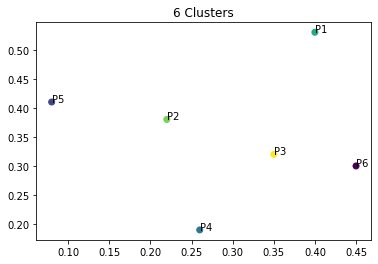

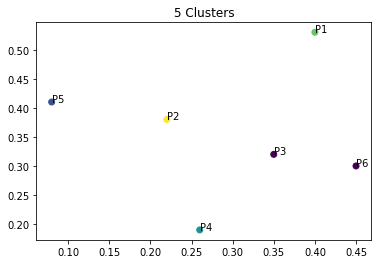

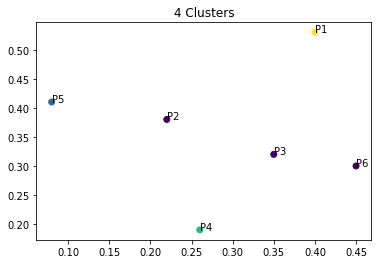

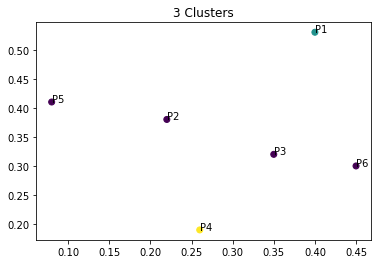

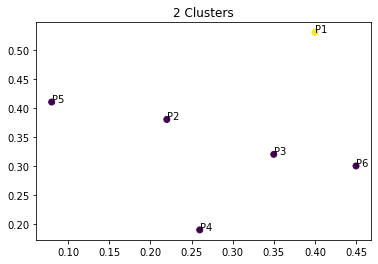

In [48]:
for i in range(5):
  iter = 6 - i
  sk_clus = AgglomerativeClustering(iter, linkage='single', compute_distances=True)
  pred = sk_clus.fit_predict(X)

  fig, ax = plt.subplots()
  ax.scatter(X[:, 0], X[:, 1], c=pred)

  for i in range(6):
      ax.annotate(f'P{i+1}', (X[i, 0], X[i, 1]))
  plt.title(f'{iter} Clusters')
  plt.show()